In [0]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import io
import string
import re

# NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducible results
np.random.seed(24)
torch.manual_seed(24)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
from google.colab import files
uploaded = files.upload()

#!rm offenseval-training-v1\ \(1\).tsv

Saving offenseval-training-v1.tsv to offenseval-training-v1 (1).tsv


In [0]:
# Load the data
df = pd.read_csv(io.StringIO(uploaded["offenseval-training-v1.tsv"].decode('utf-8')),  sep = "\t")
print(df.shape)
df.head()

(13240, 5)


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [0]:
# Load the data
#path = './Downloads/start-kit/training-v1/'
'''
path = './training-v1/'
df = pd.read_csv(path + "offenseval-training-v1.tsv", sep = "\t")
print(df.shape)
df.head()
'''

'\npath = \'./training-v1/\'\ndf = pd.read_csv(path + "offenseval-training-v1.tsv", sep = "\t")\nprint(df.shape)\ndf.head()\n'

In [0]:
df.describe(include = ['O'])

,tweet,subtask_a,subtask_b,subtask_c
count,13240,13240,4400,3876
unique,13207,2,2,3
top,@USER Looks Like The Jokes On Liberals Again. ...,NOT,TIN,IND
freq,6,8840,3876,2407


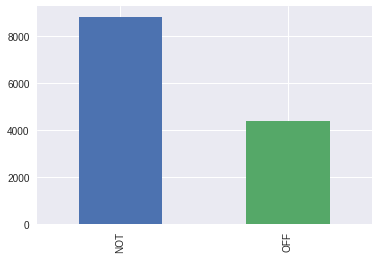

In [0]:
df['subtask_a'].value_counts().plot(kind = 'bar')

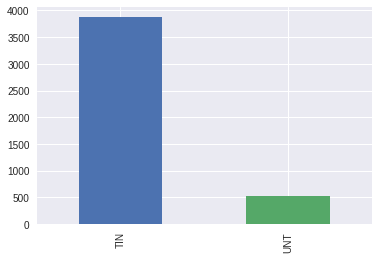

In [0]:
df['subtask_b'].value_counts().plot(kind = 'bar')

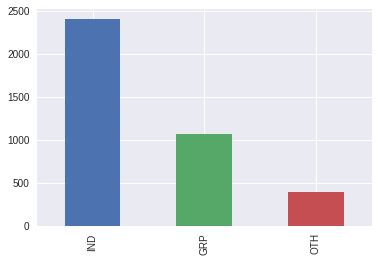

In [0]:
df['subtask_c'].value_counts().plot(kind = 'bar')

# Pre-processing of the tweets

In [0]:
#df_train['subtask_a'].value_counts().plot(kind = 'bar')

In [0]:
#@title Remove punctuation and transform to lowercase

df_prep = df.copy()
#df_prep['preprocessed_tweet'] = df_prep['tweet'].str.replace(' URL ', ' ')
df_prep['preprocessed_tweet'] = df_prep['tweet'].str.lower()
#df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[!;]', '')
df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('&amp;', '&')
df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[{}]'.format(string.punctuation), '')
df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[“”’—]', ' ')
df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('\d+', '') # Remove digits

def replace_words(dataframe, label):
  dataframe[label] = dataframe[label].str.replace('𝙿𝚎𝚝𝚊𝚕𝚜', 'Petals')
  dataframe[label] = dataframe[label].str.replace('𝙼𝚌𝙿𝙾𝚄𝚃𝚂𝙵𝚊𝚌𝚎', 'McPOUTSFace')
  dataframe[label] = dataframe[label].str.replace('ᶦˢ', 'is')
  dataframe[label] = dataframe[label].str.replace('ᴵⁿᵈᵉˣ', 'index')
  dataframe[label] = dataframe[label].str.replace('ᶠᶦʳˢᵗ', 'first')
  dataframe[label] = dataframe[label].str.replace('ᵗʰᵉ', 'the')
  dataframe[label] = dataframe[label].str.replace('ᴳᵉᵗᵗᶦⁿᵍ', 'getting')
  return dataframe
  
df_prep = replace_words(df_prep, 'preprocessed_tweet')

df_prep.head(10)

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,user she should ask a few native americans wha...
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,user user go home you re drunk user maga trump...
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,user someone shouldvetaken this piece of shit ...
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,user user obama wanted liberals illegals to m...
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH,user liberals are all kookoo
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN,user user oh noes tough shit
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP,user was literally just talking about this lol...
8,45157,@USER Buy more icecream!!!,NOT,NaN,NaN,user buy more icecream
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND,user canada doesn t need another cuck we alrea...


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(df_prep['preprocessed_tweet'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()  
print(dictionary)

dict_items([('user', 18760), ('she', 15807), ('should', 15935), ('ask', 1015), ('few', 6570), ('native', 11803), ('americans', 576), ('what', 19383), ('their', 17642), ('take', 17339), ('on', 12439), ('this', 17744), ('is', 9237), ('go', 7431), ('home', 8341), ('you', 19921), ('re', 14331), ('drunk', 5437), ('maga', 10715), ('trump', 18220), ('url', 18736), ('amazon', 551), ('investigating', 9178), ('chinese', 3030), ('employees', 5767), ('who', 19458), ('are', 921), ('selling', 15604), ('internal', 9119), ('data', 4361), ('to', 17903), ('thirdparty', 17737), ('sellers', 15603), ('looking', 10531), ('for', 6860), ('an', 606), ('edge', 5592), ('in', 8820), ('the', 17616), ('competitive', 3504), ('marketplace', 10899), ('kag', 9622), ('china', 3027), ('tcot', 17434), ('someone', 16411), ('shouldvetaken', 15943), ('piece', 13217), ('of', 12356), ('shit', 15864), ('volcano', 19029), ('obama', 12278), ('wanted', 19165), ('liberals', 10264), ('illegals', 8689), ('move', 11605), ('into', 9150

In [0]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)
vocab_bef_stem.head()

𝓭𝔂𝓼𝓹𝓱𝓸𝓻𝓲𝓪    20029
현재gt         20028
현재           20027
더보이즈         20026
너의존재가기적이야    20025
dtype: int64

In [0]:
# Search for some regex
prep_tweet = df_prep.preprocessed_tweet
#prep_tweet.str.extract(r'[^a-zA-Z]')
a = prep_tweet.apply(lambda x: re.findall('[^\x00-\x7F]',x)) #[^a-zA-Z]
#a = prep_tweet.apply(lambda x: re.findall('[]',x))
b = a[a.map(len) > 0]
b.head()

1           [👊, 🇺, 🇸, 👊]
3                    [😂]
16    [🎶, ♥, ️, ✔, ️, 🙉]
18                   [😂]
23                   [🤔]
Name: preprocessed_tweet, dtype: object

In [0]:
#@title Tokenisation
#nltk.download()
token_df = df_prep.copy()
#token_df['token_tweet'] = token_df.preprocessed_tweet.apply(nltk.word_tokenize)

'''
def tokenise_tweet(row):
    tokenised_tweet = []
    for token in row.split(' '): 
        tokenised_tweet.append(token)
    return tokenised_tweet 


#token_df['token_tweet'] = token_df.preprocessed_tweet.apply(tokenise_tweet)
'''
token_df['token_tweet'] = token_df.preprocessed_tweet.apply(lambda x: x.split())
print(token_df.token_tweet.iloc[1])
token_df.head()

['user', 'user', 'go', 'home', 'you', 're', 'drunk', 'user', 'maga', 'trump', '👊🇺🇸👊', 'url']


,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet,token_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,user she should ask a few native americans wha...,"[user, she, should, ask, a, few, native, ameri..."
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,user user go home you re drunk user maga trump...,"[user, user, go, home, you, re, drunk, user, m..."
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...,"[amazon, is, investigating, chinese, employees..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,user someone shouldvetaken this piece of shit ...,"[user, someone, shouldvetaken, this, piece, of..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,user user obama wanted liberals illegals to m...,"[user, user, obama, wanted, liberals, illegals..."


In [0]:
#@title Remove stopwords
#from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

mystopwords = stopwords + ['u', 'im', 'also']

token_df['token_tweet_stop'] = token_df['token_tweet'].apply(lambda x: [item for item in x if item not in mystopwords])
token_df.head()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

,id,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet,token_tweet,token_tweet_stop
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,user she should ask a few native americans wha...,"[user, she, should, ask, a, few, native, ameri...","[user, ask, native, americans, take]"
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,user user go home you re drunk user maga trump...,"[user, user, go, home, you, re, drunk, user, m...","[user, user, go, home, drunk, user, maga, trum..."
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon is investigating chinese employees who ...,"[amazon, is, investigating, chinese, employees...","[amazon, investigating, chinese, employees, se..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,user someone shouldvetaken this piece of shit ...,"[user, someone, shouldvetaken, this, piece, of...","[user, someone, shouldvetaken, piece, shit, vo..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,user user obama wanted liberals illegals to m...,"[user, user, obama, wanted, liberals, illegals...","[user, user, obama, wanted, liberals, illegals..."


In [0]:
sub_token_df = token_df[['id', 'token_tweet_stop', 'subtask_a', 'subtask_b', 'subtask_c']]
sub_token_df.rename(columns = {'token_tweet_stop':'tweet'}, inplace = True)

token_df.shape, sub_token_df.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


((13240, 8), (13240, 5))

In [0]:
# Create vocabulary

def vocabulary_list(dataframe, label):
  voc = [] # Let us put all the tokens (mostly words) appearing in the vocabulary in a list
  for index, row in dataframe.iterrows():
    tweet = row[label]
    for token in tweet:
        if token not in voc:
            voc.append(token)
  return voc

vocabulary = vocabulary_list(sub_token_df, 'tweet')
print(vocabulary[1:30])

vocabulary_size = len(vocabulary)
vocabulary_size

['ask', 'native', 'americans', 'take', 'go', 'home', 'drunk', 'maga', 'trump', '👊🇺🇸👊', 'url', 'amazon', 'investigating', 'chinese', 'employees', 'selling', 'internal', 'data', 'thirdparty', 'sellers', 'looking', 'edge', 'competitive', 'marketplace', 'kag', 'china', 'tcot', 'someone', 'shouldvetaken']


21024

In [0]:
sub_token_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,"[user, ask, native, americans, take]",OFF,UNT,NaN
1,90194,"[user, user, go, home, drunk, user, maga, trum...",OFF,TIN,IND
2,16820,"[amazon, investigating, chinese, employees, se...",NOT,NaN,NaN
3,62688,"[user, someone, shouldvetaken, piece, shit, vo...",OFF,UNT,NaN
4,43605,"[user, user, obama, wanted, liberals, illegals...",NOT,NaN,NaN


In [0]:
#@title Lemmatisation
porter = True

if porter:
  lemmatizer = PorterStemmer()
  sub_token_df['tweet_lemma'] = sub_token_df.tweet.apply(lambda row: [lemmatizer.stem(word)  for word in row])
else:
  lemmatizer = WordNetLemmatizer()
  sub_token_df['tweet_lemma'] = sub_token_df.tweet.apply(lambda row: [lemmatizer.lemmatize(word)  for word in row])

sub_token_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,id,tweet,subtask_a,subtask_b,subtask_c,tweet_lemma
0,86426,"[user, ask, native, americans, take]",OFF,UNT,NaN,"[user, ask, nativ, american, take]"
1,90194,"[user, user, go, home, drunk, user, maga, trum...",OFF,TIN,IND,"[user, user, go, home, drunk, user, maga, trum..."
2,16820,"[amazon, investigating, chinese, employees, se...",NOT,NaN,NaN,"[amazon, investig, chines, employe, sell, inte..."
3,62688,"[user, someone, shouldvetaken, piece, shit, vo...",OFF,UNT,NaN,"[user, someon, shouldvetaken, piec, shit, volc..."
4,43605,"[user, user, obama, wanted, liberals, illegals...",NOT,NaN,NaN,"[user, user, obama, want, liber, illeg, move, ..."


In [0]:
# Lemmatized vocabulary
voc_lemma = vocabulary_list(sub_token_df, 'tweet_lemma')
print(voc_lemma[1:30])

voc_lemma_size = len(voc_lemma)
voc_lemma_size

['ask', 'nativ', 'american', 'take', 'go', 'home', 'drunk', 'maga', 'trump', '👊🇺🇸👊', 'url', 'amazon', 'investig', 'chines', 'employe', 'sell', 'intern', 'data', 'thirdparti', 'seller', 'look', 'edg', 'competit', 'marketplac', 'kag', 'china', 'tcot', 'someon', 'shouldvetaken']


15962

In [0]:
count = {key:0 for key in voc_lemma}
for index, row in sub_token_df.iterrows():
    tweet = row.tweet_lemma
    for token in tweet:
      count[token] += 1

t = pd.DataFrame.from_dict(count, orient = 'index')
t.columns = ['count']
t_sort = t.sort_values(by = 'count', ascending = False)#, inplace = True)
t_sort.head(10)

,count
user,33389
url,2056
liber,1622
gun,1523
control,1232
like,1191
antifa,1154
conserv,1058
maga,995
peopl,929


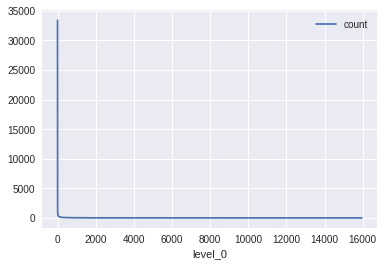

In [0]:
dft = t_sort.reset_index(level=0)
dft.reset_index(level=0, inplace = True)

dft.plot(x = 'level_0', y = 'count')

,level_0,index,count
1,1,url,2056
2,2,liber,1622
3,3,gun,1523
4,4,control,1232
5,5,like,1191


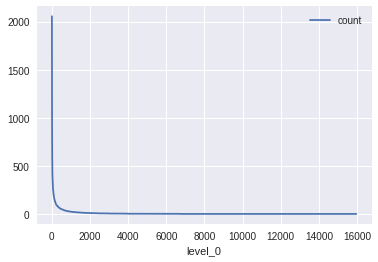

In [0]:
dft_w = dft[1:]
dft_w.plot(x = 'level_0', y = 'count')
dft_w.head()

In [0]:
dft_w.describe()

,level_0,count
count,15961.000000,15961.000000
mean,7981.000000,8.663931
std,4607.688159,44.777348
min,1.000000,1.000000
25%,3991.000000,1.000000
50%,7981.000000,1.000000
75%,11971.000000,3.000000
max,15961.000000,2056.000000


In [0]:
count['tcot']

56

In [0]:
dft_w[dft_w['count'] > 1].describe()

,level_0,count
count,6747.000000,6747.000000
mean,3374.000000,19.130132
std,1947.835465,67.481598
min,1.000000,2.000000
25%,1687.500000,2.000000
50%,3374.000000,5.000000
75%,5060.500000,13.000000
max,6747.000000,2056.000000


In [0]:
#@title Helper Functions
# We need a mapping from word to index and index to word. 

word2idx = {w: idx for (idx, w) in enumerate(voc_lemma)}
idx2word = {idx: w for (idx, w) in enumerate(voc_lemma)}

In [0]:
def look_up_table(word_idx):
    x = torch.zeros(voc_lemma_size).float()
    x[word_idx] = 1.0
    return x
  
word_idx = word2idx['want']
print(look_up_table(word_idx).shape)


torch.Size([15962])


In [0]:
#@title Extracting contexts and the center word!

# Let us assume the context size is '2'

window_size = 2

idx_pairs = []

# variables of interest: 
#   center_word_pos: center word position
#   context_word_pos: context_word_position
#   add sentence length as a constraint

for index, row in sub_token_df.iterrows():
    indices = [word2idx[word] for word in row.tweet_lemma]

    for center_word_pos in range(len(indices)):

        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
                
            context_word_idx = indices[context_word_pos]            
            idx_pairs.append((indices[center_word_pos], context_word_idx))

# print(idx_pairs)
idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array
print(idx_pairs.shape)

(607318, 2)


In [0]:
#@title Parameters and Hyperparameters

# Hyperparameters:
embedding_dims = 5
num_epochs = 10
learning_rate = 0.001


# The two weight matrices:
W1 = Variable(torch.randn(embedding_dims, voc_lemma_size).float(),  requires_grad = True)
# W1 is the 'embedding matrix' 

W2 = Variable(torch.randn(voc_lemma_size, embedding_dims).float(),  requires_grad = True)
# W2 is the 'parameter matrix'

In [0]:
#@title Training the model in the standard way


for epoch in range(num_epochs):
    start = time.time()
    print(epoch)
    loss_val = 0
    
    for data, target in idx_pairs:
      
        x = Variable(look_up_table(data)).float() # x is a variable 
        
        y_true = Variable(torch.from_numpy(np.array([target])).long()) 
        z1 = torch.matmul(W1, x) 
        
        z2 = torch.matmul(W2, z1)
       
        # Let us obtain prediction over the vocabulary
        log_softmax = F.log_softmax(z2, dim=0)
        
        # Our loss is a negative log-likelihood loss 
        
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        
        loss_val += loss.item()
        
        # propagate the error
        loss.backward()
        
        # gradient descent
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        # zero out gradient accumulation
        W1.grad.data.zero_()
        W2.grad.data.zero_()
        
        
    if epoch  >= 0:#% 10 == 0:    
        print(f'Loss at epoch {epoch}: {loss_val/len(idx_pairs)}')        

    duration = time.time() - start
    print('It takes {0:.6f} seconds to execute the epoch {1}.'.format(duration, epoch))

0
Loss at epoch 0: 10.045252153959725
It takes 912.066865 seconds to execute the epoch 0.
1
Loss at epoch 1: 9.406347234673905
It takes 914.779467 seconds to execute the epoch 1.
2
Loss at epoch 2: 9.04075407629182
It takes 909.517277 seconds to execute the epoch 2.
3
Loss at epoch 3: 8.749533918928138
It takes 916.618552 seconds to execute the epoch 3.
4
Loss at epoch 4: 8.51695005562585
It takes 920.668360 seconds to execute the epoch 4.
5
Loss at epoch 5: 8.324524216332374
It takes 921.049946 seconds to execute the epoch 5.
6
Loss at epoch 6: 8.164215579973872
It takes 909.425668 seconds to execute the epoch 6.
7
Loss at epoch 7: 8.03083775091217
It takes 897.552033 seconds to execute the epoch 7.
8
Loss at epoch 8: 7.918358806027882
It takes 894.584176 seconds to execute the epoch 8.
9
Loss at epoch 9: 7.822538292698221
It takes 898.294600 seconds to execute the epoch 9.


In [0]:
torch.save(W1, 'W1_lemma.pt')
torch.save(W2, 'W2_lemma.pt')

In [0]:
W1 = torch.load('W1_lemma.pt')
W2 = torch.load('W2_lemma.pt')
W1.shape, W2.shape

(torch.Size([5, 15962]), torch.Size([15962, 5]))

In [0]:
#@title Using embeddings

# Let us get two vectors from the trained model
from scipy.spatial.distance import euclidean

x = Variable(look_up_table(word2idx['trump'])).float()
print(x.shape)
x_emb = torch.matmul(W1, x).detach().numpy()
print(x_emb)
y = Variable(look_up_table(word2idx['amazon'])).float()
y_emb = torch.matmul(W1, y).detach().numpy()
print(y_emb)


# let us print the euclidean distance
print(euclidean(x_emb, y_emb))

# Q. What would euclidean distance do? What are we measuring in this case? (HINT: vector algebra)


torch.Size([15962])
[-0.67816085  0.05198691 -0.20996344  0.8491165  -0.15170419]
[-0.665206    0.5549344  -1.2067254  -0.60474956  0.29061174]
1.8857433795928955


In [0]:
'''
# The two weight matrices:
W1 = Variable(torch.randn(embedding_dims,  voc_lemma_size).float(), 
              requires_grad=True)
 

W2 = Variable(torch.randn(embedding_dims,  voc_lemma_size).float(), 
              requires_grad=True)


for epoch in range(num_epochs):
    start = time.time()
    print(epoch)
  
    loss_val = 0
    
    for data, target in idx_pairs:
        
        x_var = Variable(look_up_table(data)).float() 
        
        y_pos = Variable(torch.from_numpy(np.array([target])).long())
        y_pos_var = Variable(look_up_table(target)).float()
        
        neg_sample = np.random.choice(list(range( voc_lemma_size)),size=(1))[0]
        y_neg = Variable(torch.from_numpy(np.array([neg_sample])))
        y_neg_var = Variable(look_up_table(neg_sample)).float()

         
        x_emb = torch.matmul(W1, x_var) 
        y_pos_emb = torch.matmul(W2, y_pos_var)
        y_neg_emb = torch.matmul(W2, y_neg_var)
        
        
        # get positive sample score
        pos_var = torch.mul(x_emb, y_pos_emb).squeeze()        
        pos_score = F.logsigmoid(pos_var)       
        pos_loss = sum(pos_score)
        
        # get negsample score
        neg_var = torch.mul(x_emb, y_neg_emb).squeeze()      
        neg_score = F.logsigmoid(-1 * neg_var)        
        neg_loss = sum(neg_score)
        
        loss = -1 * sum([neg_loss + neg_loss])
        
        # propagate the error
        loss.backward()
        
        # gradient descent
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        # zero out gradient accumulation
        W1.grad.data.zero_()
        W2.grad.data.zero_()
        
    if epoch  >= 0:#% 10 == 0:    
        print(f'Loss at epoch {epoch}: {loss_val/len(idx_pairs)}')        

    duration = time.time() - start
    print('It takes {0:.6f} seconds to execute the epoch {1}.'.format(duration, epoch))

'''

"\n# The two weight matrices:\nW1 = Variable(torch.randn(embedding_dims,  voc_lemma_size).float(), \n              requires_grad=True)\n \n\nW2 = Variable(torch.randn(embedding_dims,  voc_lemma_size).float(), \n              requires_grad=True)\n\n\nfor epoch in range(num_epochs):\n    start = time.time()\n    print(epoch)\n  \n    loss_val = 0\n    \n    for data, target in idx_pairs:\n        \n        x_var = Variable(look_up_table(data)).float() \n        \n        y_pos = Variable(torch.from_numpy(np.array([target])).long())\n        y_pos_var = Variable(look_up_table(target)).float()\n        \n        neg_sample = np.random.choice(list(range( voc_lemma_size)),size=(1))[0]\n        y_neg = Variable(torch.from_numpy(np.array([neg_sample])))\n        y_neg_var = Variable(look_up_table(neg_sample)).float()\n\n         \n        x_emb = torch.matmul(W1, x_var) \n        y_pos_emb = torch.matmul(W2, y_pos_var)\n        y_neg_emb = torch.matmul(W2, y_neg_var)\n        \n        \n     

In [0]:
sub_token_df['len_tweet'] = sub_token_df['tweet_lemma'].apply(len)
max_len_tweet = max(sub_token_df.len_tweet)
print('Maximum number of words (tokens) in the tweet:', max_len_tweet)
sub_token_df.head()

Maximum number of words (tokens) in the tweet: 79


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,tweet,subtask_a,subtask_b,subtask_c,tweet_lemma,len_tweet
0,86426,"[user, ask, native, americans, take]",OFF,UNT,NaN,"[user, ask, nativ, american, take]",5
1,90194,"[user, user, go, home, drunk, user, maga, trum...",OFF,TIN,IND,"[user, user, go, home, drunk, user, maga, trum...",10
2,16820,"[amazon, investigating, chinese, employees, se...",NOT,NaN,NaN,"[amazon, investig, chines, employe, sell, inte...",19
3,62688,"[user, someone, shouldvetaken, piece, shit, vo...",OFF,UNT,NaN,"[user, someon, shouldvetaken, piec, shit, volc...",7
4,43605,"[user, user, obama, wanted, liberals, illegals...",NOT,NaN,NaN,"[user, user, obama, want, liber, illeg, move, ...",9


#Sub-task A

In [0]:
#@title Split the data for sub-task A into three datasets
fin_df_a = sub_token_df[['id', 'tweet_lemma', 'subtask_a']]
fin_df_a.rename(columns = {'tweet_lemma':'tweet'}, inplace = True)


# Train Test Val Split: after the word embedding
df_train, df_test = train_test_split(fin_df_a, test_size = 0.2, random_state = 24)
df_train, df_val = train_test_split(df_train, test_size = 0.25, random_state = 24)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
#df_train.head()
#tweet_ex = df_train['tweet'].iloc[3]
#tweet_ex

(7944, 3)
(2648, 3)
(2648, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
labels = df_train.subtask_a.copy()
old_labels = labels.copy()
labels[labels == 'OFF'] = 1.
labels[labels == 'NOT'] = 0.
print(labels.head())
print(labels.values)
print(labels.shape)
labels_val = labels.values.astype(dtype = 'float32')
print(type(labels_val))
torch.from_numpy(labels_val)

4985    0
3444    0
8018    0
3351    1
8658    0
Name: subtask_a, dtype: object
[0.0 0.0 0.0 ... 0.0 0.0 1.0]
(7944,)
<class 'numpy.ndarray'>


tensor([0., 0., 0.,  ..., 0., 0., 1.])

In [0]:
print(len(df_train))
df_train.head()

7944


,id,tweet,subtask_a
4985,27082,"[choke, laugh, user, consid, excel, work, user...",NOT
3444,83902,"[user, mindboggl, peopl, swear, trudeau, co, m...",NOT
8018,67830,"[user, ren, oppa, love, cute, 😊]",NOT
3351,27379,"[user, user, bipolar, keep, say, differ, shit,...",OFF
8658,18154,"[user, trip]",NOT


In [0]:
data = df_train.copy()
data['index_tweet'] = data.tweet.apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])
#data['index_tweet'] = [word2idx[tok] for tok in data['tweet'] if tok in word2idx]
data.head()

,id,tweet,subtask_a,index_tweet
4985,27082,"[choke, laugh, user, consid, excel, work, user...",NOT,"[7897, 734, 0, 1734, 2100, 545, 0, 1951, 8981,..."
3444,83902,"[user, mindboggl, peopl, swear, trudeau, co, m...",NOT,"[0, 7171, 172, 3085, 818, 2491, 3007, 820, 36,..."
8018,67830,"[user, ren, oppa, love, cute, 😊]",NOT,"[0, 11962, 11963, 119, 985, 4375]"
3351,27379,"[user, user, bipolar, keep, say, differ, shit,...",OFF,"[0, 0, 7059, 269, 341, 78, 31, 172, 782, 968]"
8658,18154,"[user, trip]",NOT,"[0, 4901]"


In [0]:
def look_up_table_sent(list_idx):
  mat = torch.zeros(len(list_idx), voc_lemma_size).float()
  for i, idx in enumerate(list_idx):
    mat[i] = look_up_table(idx)
  return mat.transpose(0, 1) # Shape: (voc_lemma_size, len(list_idx))
  
look_up_table_sent([0, 2008])

tensor([[1., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [0]:
tweet_lengths = list(data['index_tweet'].map(len).values)
len(tweet_lengths)

7944

In [0]:
def get_model_inputs(dataframe, matrix, word2idx, column, target, max_len, embedding):
  data = dataframe.copy()
  
  # convert words to index
  #data['index_tweet'] = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]
  data['index_tweet'] = data.tweet.apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])
  
  # we create a tensor of a fixed size filled with zeroes for padding

  #data_tensor = Variable(torch.zeros((len(dataframe), max_len, embedding)))#.long() # Shape: No_tweets x maximum_length of tweets x embedding
  data_tensor = Variable(torch.zeros((len(dataframe), max_len))).long()
  
  tweet_lengths = list(data['index_tweet'].map(len).values)
  
  # we fill it with the indexes
  for idx, (indices, tweet) in enumerate(zip(data['index_tweet'], tweet_lengths)):
    if idx % 1000 == 0:
      print(idx)
      
    #word = Variable(look_up_table_sent(indices)).float() # Shape: (voc_lemma_size, len(indices))
    #word_emb = torch.matmul(matrix, word).detach().numpy() # Shape: (embedding, len(indices))

    #data_tensor[idx, :tweet] = torch.FloatTensor(word_emb.transpose(1, 0))
    data_tensor[idx, :tweet] = torch.LongTensor(indices)

  # Labels
  labels = dataframe[target].copy()
  labels[labels == 'OFF'] = 1.
  labels[labels == 'NOT'] = 0.
  labels_val = labels.values.astype(dtype = 'float32')
  label_tensor = torch.from_numpy(labels_val)
  
  return data_tensor, label_tensor

train_data_tensor, train_label_tensor = get_model_inputs(df_train, W1, word2idx, 'tweet', 'subtask_a', max_len_tweet, embedding_dims)

print(train_data_tensor.shape)

0
1000
2000
3000
4000
5000
6000
7000
torch.Size([7944, 79])


In [0]:
# Validation
val_data_tensor, val_label_tensor = get_model_inputs(df_val, W1, word2idx, 'tweet', 'subtask_a', max_len_tweet, embedding_dims)
val_data_tensor_f = val_data_tensor.view(val_data_tensor.size(0), -1)

# Testing
test_data_tensor, test_label_tensor = get_model_inputs(df_test, W1, word2idx, 'tweet', 'subtask_a', max_len_tweet, embedding_dims)
test_data_tensor_f = test_data_tensor.view(test_data_tensor.size(0), -1)
'''
print(test_data_tensor_f.shape)
test_data = TensorDataset(test_data_tensor_f, test_label_tensor)
test_dl = DataLoader(test_data, batch_size = batch_size)
'''

0
1000
2000
0
1000
2000


'\nprint(test_data_tensor_f.shape)\ntest_data = TensorDataset(test_data_tensor_f, test_label_tensor)\ntest_dl = DataLoader(test_data, batch_size = batch_size)\n'

In [0]:
class FFNN(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, max_len, num_classes):
        
        super(FFNN, self).__init__()
        
        #embedding (lookup layer) layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.initial = nn.Linear(vocab_size, embedding_dim)
        #self.relu1 = nn.ReLU()
        
        #hidden layer
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        
        #activation
        self.relu2 = nn.ReLU()
        
        #output layer
        self.fc2 = nn.Linear(hidden_dim, num_classes)  
        
        #self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        embedded = self.embedding(x)
        
        # we average the embeddings of words in a sentence
        
        # Q. How to average the embeddings here?
        
        # averaged = ?
        averaged = embedded.mean(1)
        
        # (batch size, max sent length, embedding dim) to (batch size, embedding dim)
        #out = self.initial(x)
        #out = self.relu1(out)
        #out = self.fc1(out)
        out = self.fc1(averaged)
        out = self.relu2(out)
        out = self.fc2(out)
        #out = self.sig(out)
        return out


In [0]:
'''
def accuracy(output, target):

  output = torch.round(torch.sigmoid(output))
  correct = (output == target).float()
  acc = correct.sum()/len(correct)

  np_output = output.detach().numpy()
  np_target = target.detach().numpy()
  acc = accuracy_score(np_target, np_output) # True, Pred
  return acc
'''

def accuracy(output, target):
 
    output = torch.round(torch.sigmoid(output))
    correct = (output == target).float()
    acc = correct.sum()/len(correct)
    return acc


# Variables
# we will train for N epochs (N times the model will see all the data)
epochs = 20 # Number of epochs

# the input dimension is the vocabulary size
input_dim = len(word2idx) #79 * 5 # 395 #len(word2idx)
print(input_dim)

# we define our embedding dimension (dimensionality of the output of the first layer)
embedding_dim = 512

# dimensionality of the output of the second hidden layer
hidden_dim = 128

#the outut dimension is the number of classes, 1 for binary classification
output_dim = 1

batch_size = 25 #75
lr = 0.0001 #0.01 # Learning rate 

15962


In [0]:
# Data loading
# Training
train_data_tensor_f = train_data_tensor.view(train_data_tensor.size(0), -1)
print(train_data_tensor_f.shape)
train_data = TensorDataset(train_data_tensor_f, train_label_tensor)
train_dl = DataLoader(train_data, batch_size = batch_size)

torch.Size([7944, 79])


In [0]:
# recall input parameters to our model
#embedding_dim, hidden_dim, vocab_size, max_len, num_classes
# max_len is the maximum length of the input sentences as we defined during padding

# Set seed for reproducible results
torch.manual_seed(24)

# Create the neural network
model = FFNN(embedding_dim, hidden_dim, input_dim, max_len_tweet, output_dim)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr = lr)

# we use the binary cross-entropy loss with sigmoid (applied to logits) 
#Recall we did not apply any activation to our output layer, we need to make our outputs look like probality.
loss_func = nn.BCEWithLogitsLoss() # Binary cross-entropy loss with sigmoid as a loss function

# Save loss results per epoch for plots
train_loss_history, val_loss_history = [], []
# Train the neural network
for epoch in range(1, epochs+1):
  
  #to ensure the dropout (exlained later) is "turned on" while training
  #good practice to include even if do not use here
  model.train()
  
  for X_batch, y_batch in train_dl:
      optimizer.zero_grad() # Clears the gradients
      #print(X_batch.shape)
      # squeeze is needed as the predictions are initially size (batch size, 1) and we need to remove the dimension of size 1 
      pred = model(X_batch).squeeze(1)
      loss = loss_func(pred, y_batch)
      
      acc = accuracy(pred, y_batch)

      loss.backward()
      optimizer.step() # Updates the parameters thanks to the gradient
      
  epoch_loss = loss.item()
  epoch_acc = acc
      
        
  # Training log
  print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}%')
  train_loss_history += [epoch_loss]
  
  # On the validation dataset
  model.eval()
  with torch.no_grad():
    pred_val = model(val_data_tensor_f).squeeze(1)
    loss_val = loss_func(pred_val, val_label_tensor)
    acc_val = accuracy(pred_val, val_label_tensor)
    print(f'| Val Loss: {loss_val:.3f} | Test Acc: {acc_val*100:.2f}%')
    val_loss_history += [loss_val]

'''
feature = train_data_tensor
target = train_label_tensor
'''

| Epoch: 01 | Train Loss: 0.609 | Train Acc: 73.68%
| Val Loss: 0.644 | Test Acc: 66.77%


KeyboardInterrupt: ignored

In [0]:
# Test
print(test_data_tensor_f.shape)
with torch.no_grad():
  predictions = model(test_data_tensor_f).squeeze(1)
  print(min(predictions), max(predictions))
  loss = loss_func(predictions, test_label_tensor)
  acc = accuracy(predictions, test_label_tensor)
  print(predictions)
  print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')

torch.Size([2648, 79])
tensor(7.0261) tensor(12.4508)
tensor([11.8059, 12.1413,  8.5483,  ..., 12.1613,  8.8453,  8.9184])
| Test Loss: 7.203 | Test Acc: 33.95%


20 20


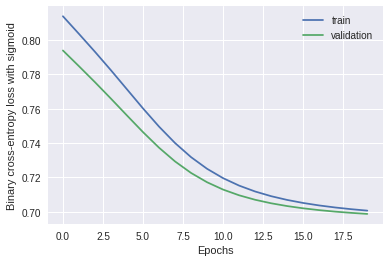

In [0]:
#@title Plot the training and validation loss

def plot_loss_curves(train, val):
    epochs = len(train)
    epoch = [i for i in range(epochs)]
    fig, ax = plt.subplots()
    ax.plot(epoch, train, label = 'train')
    ax.plot(epoch, val, label = 'validation')
    ax.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Binary cross-entropy loss with sigmoid')
    plt.show()

print(len(train_loss_history), len(val_loss_history))
plot_loss_curves(train_loss_history, val_loss_history)

In [0]:
# Confusion matrix
print(torch.round(predictions[0:10]))
print(torch.round(predictions).unique())
y_pred = torch.round(predictions).detach().numpy().astype(int)
print(y_pred)
y_true = test_label_tensor.detach().numpy().astype(int)
print(y_true)
confusion_matrix(test_label_tensor.detach().numpy(), torch.round(predictions).detach().numpy())

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.])
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


array([[1749,    0],
       [ 899,    0]])

In [0]:
# Grid search hyperparameters
lr = [0.1, 0.05, 0.01, 0.005, 0.0001]
#momentum = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
parameters = [lr]

best_acc = 0 # Initialisation
best_params = [None, None]

# Set seed for reproducible results
torch.manual_seed(24)

for param1 in parameters[0]:
  print(param1)
  #for param2 in parameters[1]:
  start = time.time()
  #print(param2)

  # Create the neural network
  model = FFNN(embedding_dim, hidden_dim, input_dim, max_len_tweet, output_dim)

  # we use the stochastic gradient descent (SGD) optimizer
  optimizer = optim.SGD(model.parameters(), lr = param1)

  # we use the binary cross-entropy loss with sigmoid (applied to logits) 
  #Recall we did not apply any activation to our output layer, we need to make our outputs look like probality.
  loss_func = nn.BCEWithLogitsLoss() # Binary cross-entropy loss with sigmoid as a loss function

  # Train the neural network
  for epoch in range(1, epochs+1):

    #to ensure the dropout (exlained later) is "turned on" while training
    #good practice to include even if do not use here
    model.train()

    for X_batch, y_batch in train_dl:
        #print(X_batch.shape)
        # squeeze is needed as the predictions are initially size (batch size, 1) and we need to remove the dimension of size 1 
        pred = model(X_batch).squeeze(1)
        loss = loss_func(pred, y_batch)

        acc = accuracy(pred, y_batch)

        loss.backward()
        optimizer.step() # Updates the parameters thanks to the gradient
        optimizer.zero_grad() # Clears the gradients

    epoch_loss = loss.item()
    epoch_acc = acc

    # Training log
    #print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}%')
    train_loss_history += [epoch_loss]

    # On the validation dataset
    model.eval()
    with torch.no_grad():
      pred_val = model(val_data_tensor_f).squeeze(1)
      loss_val = loss_func(pred_val, val_label_tensor)
      acc_val = accuracy(pred_val, val_label_tensor)
      
      if acc_val > best_acc:
        best_acc = acc_val
        best_params[0] = param1

  duration = time.time() - start
  print(duration)

best_params, best_acc

0.1
14.576356887817383
0.05
14.663591384887695
0.01
14.379608154296875
0.005
14.316754341125488
0.0001
14.325670719146729


([0.1, None], tensor(0.6681))

In [0]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, out_channels, window_size, output_dim, dropout):
        
        super(CNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #in_channels -- 1 text channel
        #out_channels -- the number of output channels
        #kernel_size is (window size x embedding dim)
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size,embedding_dim))
        
        #the dropout layer
        self.dropout = nn.Dropout(dropout)
    
        #the output layer
        self.fc = nn.Linear(out_channels, output_dim)
        
        
        
    def forward(self, x):
                
        #(batch size, max sent length)
        
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps = self.conv(embedded)
        
        #??? what is the shape of the convolution output
        
        #(batch size, n filters, max input length - window size +1)
        
        feature_maps = feature_maps.squeeze(3)
        
        #??? why do we reduce 1 dimention here
                
        feature_maps = F.relu(feature_maps)
        
  
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2])
        
        pooled = pooled.squeeze(2)
  
        #??? what is the shape of the pooling output
        #(batch size, n_filters)
        
        dropped = self.dropout(pooled)
 
        preds = self.fc(dropped)
        
        return preds


In [0]:
epochs=20

input_dim = len(word2idx)
embedding_dimm = 100
output_dim = 1

#the hyperparamerts specific to CNN

# we define the number of filters
n_out_channels = 100

# we define the window size
window_size = 1

# we apply the dropout with the probability 0.5
dropout = 0.5

model = CNN(input_dim, embedding_dim, n_out_channels, window_size, output_dim, dropout)

#model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

'''
feature_train = train_sent_tensor
target_train = train_label_tensor

feature_valid = valid_sent_tensor
target_valid = valid_label_tensor
'''

for epoch in range(1, epochs+1):
   
  model.train()
  for X_batch, y_batch in train_dl:
        #print(X_batch.shape)
        # squeeze is needed as the predictions are initially size (batch size, 1) and we need to remove the dimension of size 1 
        pred = model(X_batch).squeeze(1)
        loss = loss_func(pred, y_batch)

        acc = accuracy(pred, y_batch)
        
        loss.backward()
        optimizer.step() # Updates the parameters thanks to the gradient
        optimizer.zero_grad()
  
  epoch_loss = loss.item()
  epoch_acc = acc
  
  model.eval()
  
  with torch.no_grad():
 
    predictions_valid = model(val_data_tensor_f).squeeze(1)
    loss = loss_fn(predictions_valid, val_label_tensor)
    acc = accuracy(predictions_valid, val_label_tensor)
    valid_loss = loss.item()
    valid_acc = acc
  
  print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
  

| Epoch: 01 | Train Loss: 0.484 | Train Acc: 84.21% | Val. Loss: 0.612 | Val. Acc: 66.96% |
| Epoch: 02 | Train Loss: 0.556 | Train Acc: 78.95% | Val. Loss: 0.596 | Val. Acc: 70.54% |
| Epoch: 03 | Train Loss: 0.446 | Train Acc: 89.47% | Val. Loss: 0.581 | Val. Acc: 71.00% |
| Epoch: 04 | Train Loss: 0.474 | Train Acc: 84.21% | Val. Loss: 0.566 | Val. Acc: 71.60% |
| Epoch: 05 | Train Loss: 0.540 | Train Acc: 78.95% | Val. Loss: 0.556 | Val. Acc: 72.43% |
| Epoch: 06 | Train Loss: 0.427 | Train Acc: 78.95% | Val. Loss: 0.547 | Val. Acc: 73.23% |
| Epoch: 07 | Train Loss: 0.468 | Train Acc: 84.21% | Val. Loss: 0.537 | Val. Acc: 73.90% |
| Epoch: 08 | Train Loss: 0.415 | Train Acc: 78.95% | Val. Loss: 0.530 | Val. Acc: 74.62% |
| Epoch: 09 | Train Loss: 0.328 | Train Acc: 89.47% | Val. Loss: 0.525 | Val. Acc: 75.34% |
| Epoch: 10 | Train Loss: 0.379 | Train Acc: 78.95% | Val. Loss: 0.520 | Val. Acc: 75.38% |
| Epoch: 11 | Train Loss: 0.295 | Train Acc: 94.74% | Val. Loss: 0.515 | Val. Ac

In [0]:
# Test
print(test_data_tensor_f.shape)
with torch.no_grad():
  predictions = model(test_data_tensor_f).squeeze(1)
  print(min(predictions), max(predictions))
  loss = loss_func(predictions, test_label_tensor)
  acc = accuracy(predictions, test_label_tensor)
  print(predictions)
  print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')

torch.Size([2648, 79])
tensor(-3.9215) tensor(6.2243)
tensor([ 3.6678, -1.2404,  0.1402,  ..., -0.7050, -0.8475, -0.5932])
| Test Loss: 0.511 | Test Acc: 75.57%


In [0]:
def predict(raw_prediction):
  y = torch.round(torch.sigmoid(raw_prediction)).detach().numpy().astype(int)
  y_pred = pd.DataFrame(y, columns = ['pred'])
  return y_pred

y_pred = predict(predictions)
y_pred['class'] = 'NOT'
y_pred.loc[y_pred['pred'] == 1, 'class'] = 'OFF'

y_pred.head()

,pred,class
0,1,OFF
1,0,NOT
2,1,OFF
3,1,OFF
4,1,OFF


In [0]:
tt = submission(df_test, y_pred)
tt.head()

,id,pred
6349,52835,NaN
10627,27842,NaN
5485,98986,NaN
7709,73651,NaN
382,33709,OFF


In [0]:
# Confusion matrix
print(torch.round(torch.sigmoid(predictions)[0:10]))
print(torch.round(torch.sigmoid(predictions)).unique())
y_pred = torch.round(torch.sigmoid(predictions)).detach().numpy().astype(int)
print(y_pred)
y_true = test_label_tensor.detach().numpy().astype(int)
print(y_true)
confusion_matrix(test_label_tensor.detach().numpy(),y_pred)

tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 0.])
tensor([0., 1.])
[1 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]


array([[1595,  154],
       [ 493,  406]])

In [0]:
from google.colab import files
test_a = files.upload()

Saving testset-taska.tsv to testset-taska.tsv


In [0]:
# Load the data
df_sub_a = pd.read_csv(io.StringIO(test_a["testset-taska.tsv"].decode('utf-8')),  sep = "\t")
print(df_sub_a.shape)
df_sub_a.head()

(860, 2)


,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


In [0]:
def preprocessing_df(dataframe, label):
  # Remove punctuation, digits and some special characters
  df_prep = dataframe.copy()
  df_prep['preprocessed_tweet'] = df_prep[label].str.lower()
  df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('&amp;', '&')
  df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[{}]'.format(string.punctuation), '')
  df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('[“”’—]', ' ')
  df_prep['preprocessed_tweet'] = df_prep['preprocessed_tweet'].str.replace('\d+', '') # Remove digits
  df_prep = replace_words(df_prep, 'preprocessed_tweet')
  
  # Tokenisation
  token_df = df_prep.copy()
  token_df['token_tweet'] = token_df.preprocessed_tweet.apply(lambda x: x.split())
  
  # Remove stopwords
  token_df['token_tweet_stop'] = token_df['token_tweet'].apply(lambda x: [item for item in x if item not in mystopwords])
  
  
  sub_token_df = token_df[['id', 'token_tweet_stop']]#, 'subtask_a', 'subtask_b', 'subtask_c']]
  sub_token_df.rename(columns = {'token_tweet_stop':'tweet'}, inplace = True)
  
  return sub_token_df

df_test_a = preprocessing_df(df_sub_a, 'tweet')

# Lemmatisation
porter = True

if porter:
  lemmatizer = PorterStemmer()
  df_test_a['tweet_lemma'] = df_test_a.tweet.apply(lambda row: [lemmatizer.stem(word)  for word in row])
else:
  lemmatizer = WordNetLemmatizer()
  df_test_a['tweet_lemma'] = df_test_a.tweet.apply(lambda row: [lemmatizer.lemmatize(word)  for word in row])


df_test_a.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,id,tweet,tweet_lemma
0,15923,"[whoisq, wherestheserver, dumpnike, declasfisa...","[whoisq, wherestheserv, dumpnik, declasfisa, d..."
1,27014,"[constitutionday, revered, conservatives, hate...","[constitutionday, rever, conserv, hate, progre..."
2,30530,"[foxnews, nra, maga, potus, trump, ndamendment...","[foxnew, nra, maga, potu, trump, ndamend, rnc,..."
3,13876,"[watching, boomer, getting, news, still, parol...","[watch, boomer, get, news, still, parol, alway..."
4,60133,"[nopasaran, unity, demo, oppose, farright, lon...","[nopasaran, uniti, demo, oppos, farright, lond..."


In [0]:
def get_model_inputs_test(dataframe, word2idx, column, max_len, embedding):
  data = dataframe.copy()
  
  # convert words to index
  #data['index_tweet'] = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]
  data['index_tweet'] = data[column].apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])
  
  # we create a tensor of a fixed size filled with zeroes for padding

  #data_tensor = Variable(torch.zeros((len(dataframe), max_len, embedding)))#.long() # Shape: No_tweets x maximum_length of tweets x embedding
  data_tensor = Variable(torch.zeros((len(dataframe), max_len))).long()
  
  tweet_lengths = list(data['index_tweet'].map(len).values)
  
  # we fill it with the indexes
  for idx, (indices, tweet) in enumerate(zip(data['index_tweet'], tweet_lengths)):
    if idx % 1000 == 0:
      print(idx)
      
    #word = Variable(look_up_table_sent(indices)).float() # Shape: (voc_lemma_size, len(indices))
    #word_emb = torch.matmul(matrix, word).detach().numpy() # Shape: (embedding, len(indices))

    #data_tensor[idx, :tweet] = torch.FloatTensor(word_emb.transpose(1, 0))
    data_tensor[idx, :tweet] = torch.LongTensor(indices)
  
  return data_tensor

test_a_input = get_model_inputs_test(df_test_a, word2idx, 'tweet_lemma', max_len_tweet, embedding_dims)
print(test_a_input.shape)

0
torch.Size([860, 79])


In [0]:
with torch.no_grad():
    predictions_task_a = model(test_a_input).squeeze(1)

y_pred = predict(predictions_task_a)
y_pred['class'] = 'NOT'
y_pred.loc[y_pred['pred'] == 1, 'class'] = 'OFF'

y_pred.head()

,pred,class
0,1,OFF
1,0,NOT
2,0,NOT
3,0,NOT
4,0,NOT


In [0]:
def submission(data, pred):
  df = data.copy()
  df['pred'] = pred['class']
  return df[['id', 'pred']]


ttt = submission(df_test_a, y_pred)
ttt.head()
ttt.to_csv("result_subtask_a.csv", index = False, header = False)

In [0]:
files.download('result_subtask_a.csv')

# Sub-task B

In [0]:
# Remove non offensive tweets
fin_df_b = sub_token_df[['id', 'tweet_lemma', 'subtask_b']]
fin_df_b.rename(columns = {'tweet_lemma':'tweet'}, inplace = True)
print(fin_df_b.shape)

fin_df_b_fil =fin_df_b.dropna()
print(fin_df_b_fil.shape) # 4400

(13240, 3)
(4400, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
# Train Test Val Split: after the word embedding
df_train, df_test = train_test_split(fin_df_b_fil, test_size = 0.2, random_state = 24)
df_train, df_val = train_test_split(df_train, test_size = 0.25, random_state = 24)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
df_train.head()

(2640, 3)
(880, 3)
(880, 3)


,id,tweet,subtask_b
7981,70376,"[user, user, incit, violenc, via, twitter, acc...",TIN
721,89795,"[user, angela, hook, younger, guy, someon, wip...",TIN
6971,16743,"[user, today, collin, back, anoth, excus, vote...",TIN
6205,98434,"[user, holi, shit, way]",UNT
2932,95210,"[good, job, assholey, kill, dad, chanc, get, j...",TIN


In [0]:
def get_model_inputs_b(dataframe, matrix, word2idx, column, target, max_len, embedding):
  data = dataframe.copy()
  
  # Convert words to index
  data['index_tweet'] = data.tweet.apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])
  
  # we create a tensor of a fixed size filled with zeroes for padding
  #data_tensor = Variable(torch.zeros((len(dataframe), max_len, embedding)))#.long() # Shape: No_tweets x maximum_length of tweets x embedding
  data_tensor = Variable(torch.zeros((len(dataframe), max_len))).long()
  
  tweet_lengths = list(data['index_tweet'].map(len).values)
  
  # we fill it with the indexes
  for idx, (indices, tweet) in enumerate(zip(data['index_tweet'], tweet_lengths)):
    if idx % 1000 == 0:
      print(idx)
      
    #word = Variable(look_up_table_sent(indices)).float() # Shape: (voc_lemma_size, len(indices))
    #word_emb = torch.matmul(matrix, word).detach().numpy() # Shape: (embedding, len(indices))

    #data_tensor[idx, :tweet] = torch.FloatTensor(word_emb.transpose(1, 0))
    data_tensor[idx, :tweet] = torch.LongTensor(indices)


  # Labels
  labels = dataframe[target].copy()
  labels[labels == 'TIN'] = 1.
  labels[labels == 'UNT'] = 0.
  labels_val = labels.values.astype(dtype = 'float32')
  label_tensor = torch.from_numpy(labels_val)
  
  return data_tensor, label_tensor

train_data_tensor, train_label_tensor = get_model_inputs_b(df_train, W1, word2idx, 'tweet', 'subtask_b', max_len_tweet, embedding_dims)

print(train_data_tensor.shape)

0
1000
2000
torch.Size([2640, 79])


In [0]:
# Validation
val_data_tensor, val_label_tensor = get_model_inputs_b(df_val, W1, word2idx, 'tweet', 'subtask_b', max_len_tweet, embedding_dims)
val_data_tensor_f = val_data_tensor.view(val_data_tensor.size(0), -1)

# Testing
test_data_tensor, test_label_tensor = get_model_inputs_b(df_test, W1, word2idx, 'tweet', 'subtask_b', max_len_tweet, embedding_dims)
test_data_tensor_f = test_data_tensor.view(test_data_tensor.size(0), -1)
'''
print(test_data_tensor_f.shape)
test_data = TensorDataset(test_data_tensor_f, test_label_tensor)
test_dl = DataLoader(test_data, batch_size = batch_size)
'''

0
0


'\nprint(test_data_tensor_f.shape)\ntest_data = TensorDataset(test_data_tensor_f, test_label_tensor)\ntest_dl = DataLoader(test_data, batch_size = batch_size)\n'

In [0]:
# Data loading
# Training
train_data_tensor_f = train_data_tensor.view(train_data_tensor.size(0), -1)
print(train_data_tensor_f.shape)
train_data = TensorDataset(train_data_tensor_f, train_label_tensor)
train_dl = DataLoader(train_data, batch_size = batch_size)

torch.Size([2640, 79])


In [0]:
lr = 0.01 # Learning rate 

# recall input parameters to our model
#embedding_dim, hidden_dim, vocab_size, max_len, num_classes
# max_len is the maximum length of the input sentences as we defined during padding

# Set seed for reproducible results
torch.manual_seed(24)

# Create the neural network
model = FFNN(embedding_dim, hidden_dim, input_dim, max_len_tweet, output_dim)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr = lr)

# we use the binary cross-entropy loss with sigmoid (applied to logits) 
#Recall we did not apply any activation to our output layer, we need to make our outputs look like probality.
loss_func = nn.BCEWithLogitsLoss() # Binary cross-entropy loss with sigmoid as a loss function

# Save loss results per epoch for plots
train_loss_history, val_loss_history = [], []
# Train the neural network
for epoch in range(1, epochs+1):
  
  #to ensure the dropout (exlained later) is "turned on" while training
  #good practice to include even if do not use here
  model.train()
  
  for X_batch, y_batch in train_dl:
      #print(X_batch.shape)
      # squeeze is needed as the predictions are initially size (batch size, 1) and we need to remove the dimension of size 1 
      pred = model(X_batch).squeeze(1)
      loss = loss_func(pred, y_batch)
      
      acc = accuracy(pred, y_batch)

      loss.backward()
      optimizer.step() # Updates the parameters thanks to the gradient
      optimizer.zero_grad() # Clears the gradients
      
  epoch_loss = loss.item()
  epoch_acc = acc
      
        
  # Training log
  print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}%')
  train_loss_history += [epoch_loss]
  
  # On the validation dataset
  model.eval()
  with torch.no_grad():
    pred_val = model(val_data_tensor_f).squeeze(1)
    loss_val = loss_func(pred_val, val_label_tensor)
    acc_val = accuracy(pred_val, val_label_tensor)
    print(f'| Val Loss: {loss_val:.3f} | Test Acc: {acc_val*100:.2f}%')
    val_loss_history += [loss_val]

'''
feature = train_data_tensor
target = train_label_tensor
'''

| Epoch: 01 | Train Loss: 0.523 | Train Acc: 80.00%
| Val Loss: 0.393 | Test Acc: 87.39%
| Epoch: 02 | Train Loss: 0.543 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 03 | Train Loss: 0.548 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 04 | Train Loss: 0.549 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 05 | Train Loss: 0.549 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 06 | Train Loss: 0.549 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 07 | Train Loss: 0.549 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 08 | Train Loss: 0.549 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 09 | Train Loss: 0.549 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 10 | Train Loss: 0.548 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 11 | Train Loss: 0.548 | Train Acc: 80.00%
| Val Loss: 0.389 | Test Acc: 87.39%
| Epoch: 12 | Train L

'\nfeature = train_data_tensor\ntarget = train_label_tensor\n'

In [0]:
# Test
print(test_data_tensor_f.shape)
with torch.no_grad():
  predictions = model(test_data_tensor_f).squeeze(1)
  loss = loss_func(predictions, test_label_tensor)
  acc = accuracy(predictions, test_label_tensor)
  print(predictions[0:10])
  print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')

torch.Size([880, 79])
tensor([2.1300, 1.9800, 1.9293, 2.1906, 2.0008, 2.1520, 1.9867, 1.8858, 2.0470,
        1.6365])
| Test Loss: 0.348 | Test Acc: 89.32%


In [0]:
# Confusion matrix
confusion_matrix(test_label_tensor, predictions)

ValueError: ignored

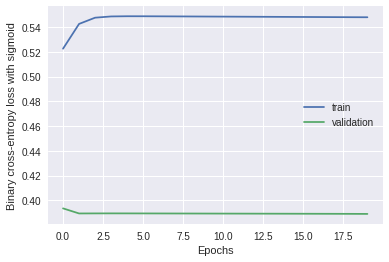

In [0]:
plot_loss_curves(train_loss_history, val_loss_history)

In [0]:
print(min(predictions), max(predictions))

tensor(1.4002) tensor(2.2403)


# Sub-task C

In [0]:
# Remove untargeted offensive tweets
fin_df_c = sub_token_df[['id', 'tweet_lemma', 'subtask_c']]
fin_df_c.rename(columns = {'tweet_lemma':'tweet'}, inplace = True)
print(fin_df_c.shape)

fin_df_c_fil =fin_df_c.dropna()
print(fin_df_c_fil.shape) # 3876

(13240, 3)
(3876, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
# Train Test Val Split: after the word embedding
df_train, df_test = train_test_split(fin_df_c_fil, test_size = 0.2, random_state = 24)
df_train, df_val = train_test_split(df_train, test_size = 0.25, random_state = 24)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
df_train.head()

(2325, 3)
(775, 3)
(776, 3)


,id,tweet,subtask_c
7426,26171,"[long, ass, blog, might, make, sens, url]",OTH
7012,40282,"[user, one, crazi, person]",IND
11813,59464,"[user, user, probabl, violent, liber, antifa, ...",IND
7689,81738,"[user, wrong, percent, time, bed, lay, suntan,...",IND
9675,40262,"[user, user, yep, produc, articl, shut, liber]",GRP


In [0]:
def get_model_inputs_c(dataframe, matrix, word2idx, column, target, max_len, embedding):
  data = dataframe.copy()
  
  # Convert words to index
  data['index_tweet'] = data.tweet.apply(lambda x: [word2idx[tok] for tok in x if tok in word2idx])
  
  # we create a tensor of a fixed size filled with zeroes for padding

  data_tensor = Variable(torch.zeros((len(dataframe), max_len, embedding)))#.long() # Shape: No_tweets x maximum_length of tweets x embedding
  
  tweet_lengths = list(data['index_tweet'].map(len).values)
  
  # we fill it with the indexes
  for idx, (indices, tweet) in enumerate(zip(data['index_tweet'], tweet_lengths)):
    if idx % 1000 == 0:
      print(idx)
    word = Variable(look_up_table_sent(indices)).float() # Shape: (voc_lemma_size, len(indices))
    word_emb = torch.matmul(matrix, word).detach().numpy() # Shape: (embedding, len(indices))

    data_tensor[idx, :tweet] = torch.FloatTensor(word_emb.transpose(1, 0))

  # Labels
  #labels = dataframe[target].copy()
  labels = pd.get_dummies(dataframe[target].copy())
  labels_val = labels.values.astype(dtype = 'float32')
  label_tensor = torch.from_numpy(labels_val)
  
  return data_tensor, label_tensor

train_data_tensor, train_label_tensor = get_model_inputs_c(df_train, W1, word2idx, 'tweet', 'subtask_c', max_len_tweet, embedding_dims)

print(train_data_tensor.shape)
print(train_label_tensor.shape)

0
1000
2000
torch.Size([2325, 79, 5])
torch.Size([2325, 3])


In [0]:
# Validation
val_data_tensor, val_label_tensor = get_model_inputs_c(df_val, W1, word2idx, 'tweet', 'subtask_c', max_len_tweet, embedding_dims)
val_data_tensor_f = val_data_tensor.view(val_data_tensor.size(0), -1)

# Testing
test_data_tensor, test_label_tensor = get_model_inputs_c(df_test, W1, word2idx, 'tweet', 'subtask_c', max_len_tweet, embedding_dims)
test_data_tensor_f = test_data_tensor.view(test_data_tensor.size(0), -1)


0
0


In [0]:
# Data loading
# Training
train_data_tensor_f = train_data_tensor.view(train_data_tensor.size(0), -1)
print(train_data_tensor_f.shape)
train_data = TensorDataset(train_data_tensor_f, train_label_tensor)
train_dl = DataLoader(train_data, batch_size = batch_size)

torch.Size([2325, 395])


In [0]:
output_dim = 3
lr = 0.01 # Learning rate 

def mult_accuracy(output, target):
    acc_list = []
    for i in range(3):
      acc_list += [accuracy(torch.round(output[:, i]), target[:, i])]
    return sum(acc_list) / len(acc_list)


# recall input parameters to our model
#embedding_dim, hidden_dim, vocab_size, max_len, num_classes
# max_len is the maximum length of the input sentences as we defined during padding

# Set seed for reproducible results
torch.manual_seed(24)

# Create the neural network
model = FFNN(embedding_dim, hidden_dim, input_dim, max_len_tweet, output_dim)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr = lr)

# we use the binary cross-entropy loss with sigmoid (applied to logits) 
#Recall we did not apply any activation to our output layer, we need to make our outputs look like probality.
loss_func = nn.BCEWithLogitsLoss() # Binary cross-entropy loss with sigmoid as a loss function

# Save loss results per epoch for plots
train_loss_history, val_loss_history = [], []
# Train the neural network
for epoch in range(1, epochs+1):
  
  #to ensure the dropout (exlained later) is "turned on" while training
  #good practice to include even if do not use here
  model.train()
  
  for X_batch, y_batch in train_dl:
      #print(X_batch.shape)
      # squeeze is needed as the predictions are initially size (batch size, 1) and we need to remove the dimension of size 1 
      pred = model(X_batch).squeeze(1)
      loss = loss_func(pred, y_batch)
      
      acc = mult_accuracy(pred, y_batch)

      loss.backward()
      optimizer.step() # Updates the parameters thanks to the gradient
      optimizer.zero_grad() # Clears the gradients
      
  epoch_loss = loss.item()
  epoch_acc = acc
      
        
  # Training log
  print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.3f} | Train Acc: {epoch_acc*100:.2f}%')
  train_loss_history += [epoch_loss]
  
  # On the validation dataset
  model.eval()
  with torch.no_grad():
    pred_val = model(val_data_tensor_f).squeeze(1)
    loss_val = loss_func(pred_val, val_label_tensor)
    acc_val = mult_accuracy(pred_val, val_label_tensor)
    print(f'| Val Loss: {loss_val:.3f} | Test Acc: {acc_val*100:.2f}%')
    val_loss_history += [loss_val]



| Epoch: 01 | Train Loss: 0.805 | Train Acc: 54.67%
| Val Loss: 0.806 | Test Acc: 47.61%
| Epoch: 02 | Train Loss: 0.803 | Train Acc: 60.00%
| Val Loss: 0.804 | Test Acc: 56.00%
| Epoch: 03 | Train Loss: 0.801 | Train Acc: 75.11%
| Val Loss: 0.803 | Test Acc: 70.62%
| Epoch: 04 | Train Loss: 0.800 | Train Acc: 80.44%
| Val Loss: 0.802 | Test Acc: 72.90%
| Epoch: 05 | Train Loss: 0.798 | Train Acc: 80.44%
| Val Loss: 0.800 | Test Acc: 73.08%
| Epoch: 06 | Train Loss: 0.796 | Train Acc: 80.44%
| Val Loss: 0.799 | Test Acc: 73.08%
| Epoch: 07 | Train Loss: 0.795 | Train Acc: 80.44%
| Val Loss: 0.797 | Test Acc: 73.16%
| Epoch: 08 | Train Loss: 0.793 | Train Acc: 80.44%
| Val Loss: 0.796 | Test Acc: 73.16%
| Epoch: 09 | Train Loss: 0.791 | Train Acc: 80.44%
| Val Loss: 0.794 | Test Acc: 73.20%
| Epoch: 10 | Train Loss: 0.790 | Train Acc: 80.44%
| Val Loss: 0.793 | Test Acc: 73.20%
| Epoch: 11 | Train Loss: 0.788 | Train Acc: 80.44%
| Val Loss: 0.791 | Test Acc: 73.20%
| Epoch: 12 | Train L

In [0]:
# Test
print(test_data_tensor_f.shape)
with torch.no_grad():
  predictions = model(test_data_tensor_f).squeeze(1)
  loss = loss_func(predictions, test_label_tensor)
  acc = mult_accuracy(torch.round(predictions), test_label_tensor)
  print(torch.round(predictions[0:10]))
  print(test_label_tensor[0:10])
  print(f'| Test Loss: {loss:.3f} | Test Acc: {acc*100:.2f}%')

torch.Size([776, 395])
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])
| Test Loss: 0.775 | Test Acc: 73.15%


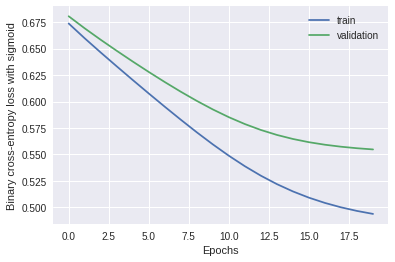

In [0]:
plot_loss_curves(train_loss_history, val_loss_history)

In [0]:
# Confusion matrix
print(torch.round(predictions[0:10]))
print(torch.round(predictions[:, 1]).unique())
y_pred = torch.round(predictions).detach().numpy().astype(int)
print(y_pred)
y_true = test_label_tensor.detach().numpy().astype(int)
print(y_true)

print(np.argmax(y_pred))
  
#confusion_matrix(test_label_tensor.detach().numpy(), torch.round(predictions).detach().numpy())

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])
tensor([0., 1.])
[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]
[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
1
